In [1]:
import os
import glob
from PIL import Image
from torch.utils.data import Dataset

class ACDCDataset(Dataset):
    """
    A custom dataset that loads ACDC images from 'rgb_anon' folders 
    for a classification task into one of four adverse conditions:
    [fog, night, rain, snow].
    """
    def __init__(self, root, split="train", transform=None):
        """
        Args:
            root (str): Path to the root ACDC directory.
            split (str): Which split to use: 'train', 'val', 'train_ref', etc.
            transform (callable, optional): Optional transform to be applied 
                on a sample (e.g., torchvision transforms).
        """
        super().__init__()
        self.root = root
        self.split = split
        self.transform = transform
        
        # Map each adverse condition to a numeric label
        self.condition2label = {
            'fog':    0,
            'night':  1,
            'rain':   2,
            'snow':   3,
            'normal': 4  # e.g., for *ref splits
        }
        
        self.image_paths = []
        self.labels = []
        
        # We read images from "rgb_anon/<condition>/<split>/**.png"
        for condition, label in self.condition2label.items():
            pattern = os.path.join(
                self.root,         # ACDC root
                "rgb_anon",        # subdirectory with anonymized RGB images
                condition,         # which adverse condition
                self.split,        # which split: train, val, etc.
                "*",               # sequence folders
                "*.png"            # all png images
            )
            # Collect all images matching the pattern
            file_list = glob.glob(pattern)
            for fpath in file_list:
                self.image_paths.append(fpath)
                self.labels.append(label)
        
        # Sort them just to have a stable order (optional)
        # This can also help with reproducibility if you rely on a certain order
        data = sorted(zip(self.image_paths, self.labels))
        self.image_paths, self.labels = zip(*data)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load and convert to RGB
        image = Image.open(img_path).convert("RGB")
        
        # Apply transformations if provided (e.g., augmentations, normalization)
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [2]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Example transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    # Normalize using ImageNet stats (common for pretrained networks)
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Paths (update these to your actual dataset location)
root_dir = r"C:\Users\janmi\PycharmProjects\Magisterka\.venv\Adverse_weather_detection\ACDC"

# Create dataset objects
train_dataset = ACDCDataset(root=root_dir, split="train", transform=train_transform)
val_dataset   = ACDCDataset(root=root_dir, split="val",   transform=val_transform)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=8)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=8)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Number of classes (fog, night, rain, snow, normal)
NUM_CLASSES = 5

# Load a pretrained ResNet18
model = models.resnet18(pretrained=True)

# Replace the final FC layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)

# Send to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


cuda


C:\Users\janmi\PycharmProjects\Magisterka\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\janmi\PycharmProjects\Magisterka\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

EPOCHS = 10
best_val_acc = 0.0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, device)
    
    print(f"[Epoch {epoch+1:02d}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save the model if it improves on validation
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_acdc_classification.pth")


In [ ]:
import os
import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from tqdm import tqdm

#########################################
#       Custom Dataset Definition       #
#########################################
class ACDCDataset(Dataset):
    """
    A custom dataset that loads ACDC images from 'rgb_anon' folders 
    for a classification task into one of four adverse conditions:
    [fog, night, rain, snow] (and optionally 'normal').
    """
    def __init__(self, root, split="train", transform=None):
        """
        Args:
            root (str): Path to the root ACDC directory.
            split (str): Which split to use: 'train', 'val', etc.
            transform (callable, optional): Optional transform to be applied 
                on a sample.
        """
        super().__init__()
        self.root = root
        self.split = split
        self.transform = transform
        
        # Map each condition to a numeric label.
        self.condition2label = {
            'fog':    0,
            'night':  1,
            'rain':   2,
            'snow':   3,
            'normal': 4  # For reference splits, if applicable.
        }
        
        self.image_paths = []
        self.labels = []
        
        # Images are expected in: root/rgb_anon/<condition>/<split>/*/*.png
        for condition, label in self.condition2label.items():
            pattern = os.path.join(
                self.root,
                "rgb_anon",
                condition,
                self.split,
                "*",       # Sequence folders
                "*.png"    # Image files
            )
            file_list = glob.glob(pattern)
            for fpath in file_list:
                self.image_paths.append(fpath)
                self.labels.append(label)
        
        # Sort the data for reproducibility (optional)
        data = sorted(zip(self.image_paths, self.labels))
        self.image_paths, self.labels = zip(*data)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Open image and convert to RGB
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

#########################################
#          Transforms & Datasets         #
#########################################
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Set your dataset root path (update this to your actual location)
root_dir = r"C:\Users\janmi\PycharmProjects\Magisterka\.venv\Adverse_weather_detection\ACDC"

# Create dataset objects
train_dataset = ACDCDataset(root=root_dir, split="train", transform=train_transform)
val_dataset   = ACDCDataset(root=root_dir, split="val",   transform=val_transform)

#########################################
#          Device and DataLoader         #
#########################################
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == 'cuda':
    print("GPU:", torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True  # May improve performance on fixed input sizes

# Set pin_memory True if using CUDA
pin_memory = True if device.type == 'cuda' else False

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=8, pin_memory=pin_memory)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=8, pin_memory=pin_memory)

#########################################
#            Model & Optimizer           #
#########################################
NUM_CLASSES = 5

# Load a pretrained ResNet18 and replace the final FC layer
model = models.resnet18(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Optionally, set up a learning rate scheduler (e.g., ReduceLROnPlateau)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# (Optional) Setup AMP for mixed-precision training if using CUDA
scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

#########################################
#        Training and Evaluation         #
#########################################
EPOCHS = 10
best_val_acc = 0.0

for epoch in range(EPOCHS):
    # -----------------------
    #       Training
    # -----------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Training", leave=False)
    for images, labels in train_bar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        if scaler is not None:
            # Use mixed precision
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        train_bar.set_postfix(loss=loss.item())
    
    train_loss = running_loss / total
    train_acc = 100.0 * correct / total

    # -----------------------
    #      Validation
    # -----------------------
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Validation", leave=False)
    with torch.no_grad():
        for images, labels in val_bar:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            val_bar.set_postfix(loss=loss.item())
    
    val_loss = running_loss / total
    val_acc = 100.0 * correct / total

    # (Optional) Step the scheduler if you are using one.
    # scheduler.step(val_acc)
    
    print(f"[Epoch {epoch+1:02d}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save the model if it improves on validation accuracy.
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_acdc_classification.pth")


Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Ti


C:\Users\janmi\PycharmProjects\Magisterka\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\janmi\PycharmProjects\Magisterka\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 Training:   0%|          | 0/100 [00:00<?, ?it/s]

data_root/
├── fog/
│   ├── train/
│   │   ├── fog/
│   │   └── clear/
│   ├── val/
│   │   ├── fog/
│   │   └── clear/
│   └── test/
│       ├── fog/
│       └── clear/
├── rain/
│   ├── train/
│   │   ├── rain/
│   │   └── clear/
│   ├── val/
│   │   ├── rain/
│   │   └── clear/
│   └── test/
│       ├── rain/
│       └── clear/
├── snow/
│   ├── train/
│   │   ├── snow/
│   │   └── clear/
│   ├── val/
│   │   ├── snow/
│   │   └── clear/
│   └── test/
│       ├── snow/
│       └── clear/
└── night/
    ├── train/
    │   ├── night/
    │   └── clear/
    ├── val/
    │   ├── night/
    │   └── clear/
    └── test/
        ├── night/
        └── clear/


Using device: cuda

=== Training model for condition: fog vs. clear ===
Classes in this dataset: ['clear', 'fog']


C:\Users\janmi\PycharmProjects\Magisterka\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\janmi\PycharmProjects\Magisterka\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] Train Loss: 0.1255, Train Acc: 0.9413 | Val Loss: 0.0019, Val Acc: 1.0000
Epoch [2/10] Train Loss: 0.0018, Train Acc: 1.0000 | Val Loss: 0.0011, Val Acc: 1.0000
Epoch [3/10] Train Loss: 0.0006, Train Acc: 1.0000 | Val Loss: 0.0006, Val Acc: 1.0000
Epoch [4/10] Train Loss: 0.0006, Train Acc: 1.0000 | Val Loss: 0.0004, Val Acc: 1.0000
Epoch [5/10] Train Loss: 0.0005, Train Acc: 1.0000 | Val Loss: 0.0004, Val Acc: 1.0000
Epoch [6/10] Train Loss: 0.0003, Train Acc: 1.0000 | Val Loss: 0.0004, Val Acc: 1.0000
Epoch [7/10] Train Loss: 0.0003, Train Acc: 1.0000 | Val Loss: 0.0003, Val Acc: 1.0000
Epoch [8/10] Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 0.0003, Val Acc: 1.0000
Epoch [9/10] Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 0.0003, Val Acc: 1.0000
Epoch [10/10] Train Loss: 0.0004, Train Acc: 1.0000 | Val Loss: 0.0002, Val Acc: 1.0000
[FOG vs. CLEAR] Test Loss: 0.0001, Test Acc: 1.0000
Saved model to model_fog.pth

=== Training model for condition: rain vs. clea

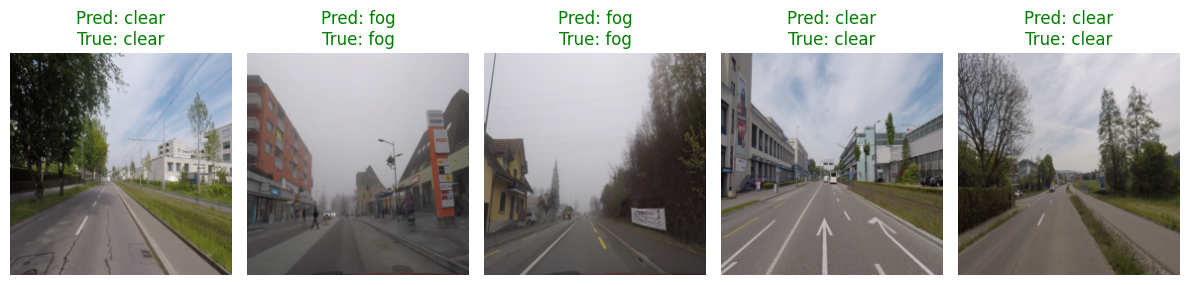


=== Visualizing predictions for: rain vs. clear ===


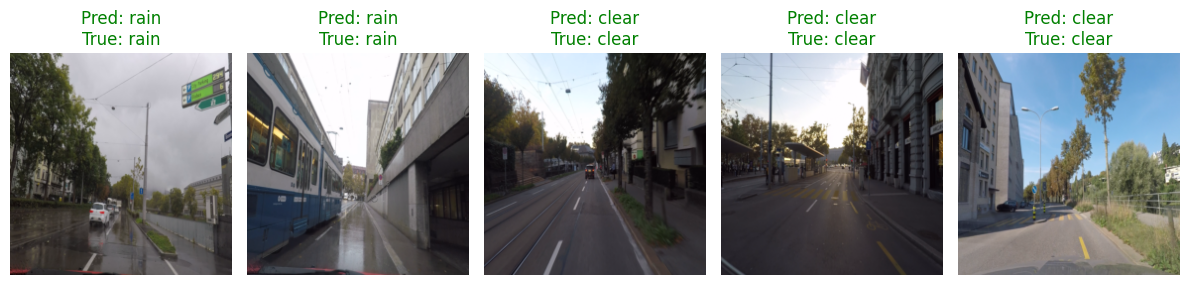


=== Visualizing predictions for: snow vs. clear ===


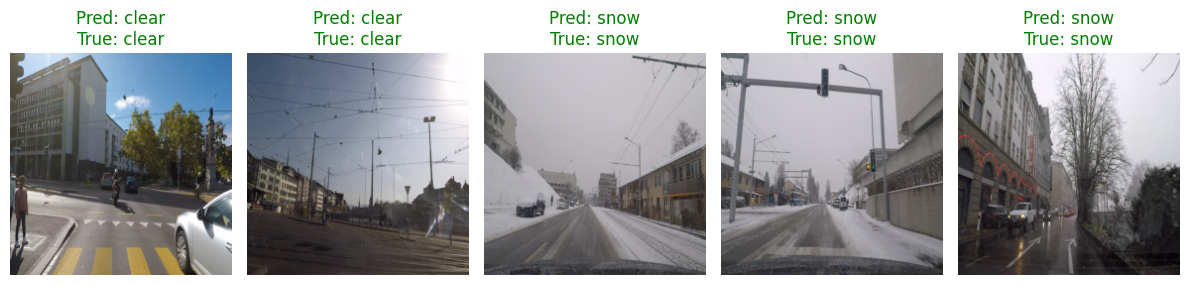


=== Visualizing predictions for: night vs. clear ===


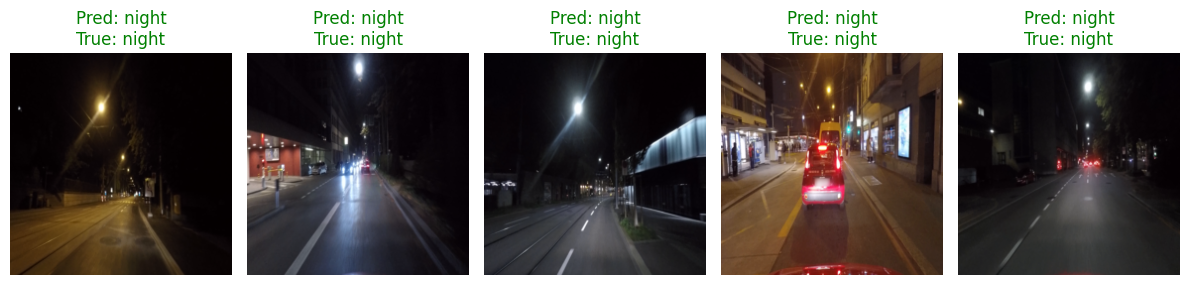

In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models


def train_model_for_condition(
    data_dir: str,
    condition: str,
    num_epochs: int = 5,
    batch_size: int = 32,
    lr: float = 1e-4,
    image_size: int = 224,
    device: str = "cpu"
):
    """
    Trains a binary classifier to distinguish between the given `condition` vs. `clear`.
    Saves the trained model weights (model_{condition}.pth).
    
    Args:
        data_dir (str): Path to the folder containing subfolders for `condition`.
                        Inside `data_dir/condition/`, we expect train/, val/, test/.
        condition (str): Condition name, e.g. "fog", "rain", "snow", "night".
        num_epochs (int): Number of epochs to train.
        batch_size (int): Batch size for DataLoader.
        lr (float): Learning rate for optimizer.
        image_size (int): Size to which images are resized.
        device (str): "cuda" or "cpu".
    """
    print(f"\n=== Training model for condition: {condition} vs. clear ===")

    # Paths
    train_dir = os.path.join(data_dir, condition, "train")
    val_dir   = os.path.join(data_dir, condition, "val")
    test_dir  = os.path.join(data_dir, condition, "test")

    # Transforms (using typical ImageNet normalization)
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]

    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    val_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Datasets and DataLoaders
    train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
    val_dataset   = datasets.ImageFolder(root=val_dir,   transform=val_transform)
    test_dataset  = datasets.ImageFolder(root=test_dir,  transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

    # Confirm classes (should be something like [clear, fog] or [fog, clear])
    print("Classes in this dataset:", train_dataset.classes)

    # Load a pretrained ResNet18, adjust the final FC for 2 classes
    model = models.resnet18(pretrained=True)
    # If you want to freeze feature layers, uncomment:
    # for param in model.parameters():
    #     param.requires_grad = False

    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)  # 2 classes
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accuracy stats
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).item()

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects / len(train_dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * images.size(0)
                val_corrects += torch.sum(preds == labels.data).item()

        val_epoch_loss = val_loss / len(val_dataset)
        val_epoch_acc = val_corrects / len(val_dataset)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
    
    # Test
    model.eval()
    test_corrects = 0
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            test_loss += loss.item() * images.size(0)
            test_corrects += torch.sum(preds == labels.data).item()

    test_loss /= len(test_dataset)
    test_acc = test_corrects / len(test_dataset)
    print(f"[{condition.upper()} vs. CLEAR] Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    # Save model
    model_path = f"model_{condition}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Saved model to {model_path}")


def load_model_for_condition(condition: str, device="cpu"):
    """
    Loads a ResNet18 model with 2 output classes from 'model_{condition}.pth'.
    Returns the model in eval mode.
    """
    model = models.resnet18()
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)  # 2 classes
    state_dict = torch.load(f"model_{condition}.pth", map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    return model


def visualize_predictions(
    model,
    test_dir: str,
    device: str = "cpu",
    num_images: int = 5,
    image_size: int = 224
):
    """
    Randomly picks some images from `test_dir`, runs inference using `model`,
    and visualizes predictions vs. ground truth.
    
    Args:
        model: A PyTorch model in eval mode.
        test_dir (str): Path to the test directory (which has subfolders for 2 classes).
        device (str): "cuda" or "cpu".
        num_images (int): Number of images to visualize.
        image_size (int): Resize dimension (width, height).
    """
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]

    test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Load the dataset
    test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
    # We'll pick samples randomly
    indices = list(range(len(test_dataset)))
    random.shuffle(indices)
    chosen_indices = indices[:num_images]

    # Class names (should be something like ["clear", "fog"] or vice versa)
    class_names = test_dataset.classes

    # Helper to invert normalization (for display)
    def unnormalize(tensor_img):
        # tensor_img shape: (C, H, W)
        for c in range(3):
            tensor_img[c] = tensor_img[c] * std[c] + mean[c]
        # Clip to [0, 1]
        tensor_img = torch.clamp(tensor_img, 0., 1.)
        return tensor_img

    # Plot each image
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(chosen_indices):
        img, label = test_dataset[idx]
        # shape of img is (C, H, W); we need a batch dimension
        img_batch = img.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(img_batch)
            _, preds = torch.max(outputs, 1)

        predicted_class = class_names[preds.item()]
        true_class      = class_names[label]

        # Un-normalize for display
        img_for_display = unnormalize(img.clone()).permute(1, 2, 0).cpu().numpy()

        plt.subplot(1, num_images, i+1)
        plt.imshow(img_for_display)
        color = "green" if predicted_class == true_class else "red"
        plt.title(f"Pred: {predicted_class}\nTrue: {true_class}", color=color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Root directory for all conditions
    data_root = r"C:\Users\janmi\PycharmProjects\Magisterka\.venv\Adverse_weather_detection\ACDC\rgb_anon_concat"  # Path to your data root folder
    # Conditions you want to train on
    conditions = ["fog", "rain", "snow", "night"]

    # Choose device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # 1. Train and save a model for each condition
    for cond in conditions:
        train_model_for_condition(
            data_dir=data_root,
            condition=cond,
            num_epochs=10,   # adjust as needed
            batch_size=32,
            lr=1e-4,
            image_size=224,
            device=device
        )

    # 2. Visualize predictions from each model on random images from its test set
    for cond in conditions:
        print(f"\n=== Visualizing predictions for: {cond} vs. clear ===")
        # Load the model
        model = load_model_for_condition(cond, device=device)
        
        # Path to the condition's test folder
        test_dir = os.path.join(data_root, cond, "test")
        
        # Visualize a few random images
        visualize_predictions(
            model=model,
            test_dir=test_dir,
            device=device,
            num_images=5,    # how many images to display
            image_size=224
        )
